In [1]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBClassifier

%matplotlib inline

/Users/vinayaknigam/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/vinayaknigam/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
deliveries = pd.read_csv("data/deliveries.csv")
matches = pd.read_csv("data/matches.csv")

In [3]:
# data preprocessing

In [4]:
deliveries = pd.merge(deliveries, matches[['id','season', 'winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')

deliveries.player_dismissed.fillna(0,inplace=True)

deliveries['player_dismissed'].loc[deliveries['player_dismissed'] != 0] = 1

grouped_df = deliveries.groupby(['match_id', 'inning', 'over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']]

df = grouped_df.agg(['sum']).reset_index()

df.columns = df.columns.get_level_values(0)

/Users/vinayaknigam/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
df['inn_wickets'] = df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()

df['inn_score'] = df.groupby(['match_id', 'inning'])['total_runs'].cumsum()

df.head(50)

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,inn_wickets,inn_score
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42
5,1,1,6,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,17,0,1,59
6,1,1,7,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,5,0,1,64
7,1,1,8,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,11,0,1,75
8,1,1,9,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,84
9,1,1,10,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,88


In [6]:
t_df = df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()

t_df = t_df.loc[t_df['inning']==1,:]

t_df['inning'] = 2

t_df.columns = ['match_id', 'inning', 'score_target']

df = df.merge(t_df, how='left', on = ['match_id', 'inning'])

df['score_target'].fillna(-1, inplace=True)

# get the remaining target #
def get_remaining_target(r):
    if r['score_target'] == -1.:
        return -1
    else:
        return r['score_target'] - r['inn_score']

df['remaining_target'] = df.apply(lambda r: get_remaining_target(r),axis=1)

df['run_rate'] = df['inn_score'] / df['over']

def get_required_run_rate(r):
    if r['remaining_target'] == -1:
        return -1.
    elif r['over'] == 20:
        return 99
    else:
        return r['remaining_target'] / (20 - r['over'])
    
df['required_run_rate'] = df.apply(lambda r: get_required_run_rate(r), axis=1)

def get_run_rate_diff(r):
    if r['inning'] == 1:
        return -1
    else:
        return r['run_rate'] - r['required_run_rate']
    
df['runrate_diff'] = df.apply(lambda r: get_run_rate_diff(r), axis=1)

df['is_batting_team'] = (df['team1'] == df['batting_team']).astype('int')

df['target'] = (df['team1'] == df['winner']).astype('int')

df.head(10)

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,inn_wickets,inn_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,1
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000,-1.0,-1.0,1,1
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667,-1.0,-1.0,1,1
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000,-1.0,-1.0,1,1
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000,-1.0,-1.0,1,1
5,1,1,6,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,17,0,1,59,-1.0,-1.0,9.833333,-1.0,-1.0,1,1
6,1,1,7,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,5,0,1,64,-1.0,-1.0,9.142857,-1.0,-1.0,1,1
7,1,1,8,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,11,0,1,75,-1.0,-1.0,9.375000,-1.0,-1.0,1,1
8,1,1,9,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,84,-1.0,-1.0,9.333333,-1.0,-1.0,1,1
9,1,1,10,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,88,-1.0,-1.0,8.800000,-1.0,-1.0,1,1


In [7]:
x_columns = ['match_id','inning', 'over', 'total_runs', 'player_dismissed', 'inn_wickets', 'inn_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

indices = np.unique(df.match_id.values)

train_indices = np.random.choice(indices,int(indices.size * 0.99))

train_indices = np.sort(train_indices)

train_set = df.loc[df.match_id.isin(train_indices)]
test_set = df.loc[~df.match_id.isin(train_indices)]

X_train = train_set[x_columns[:]]
y_train = train_set[['match_id','target']]

X_test =  test_set[x_columns[:]]
y_test = test_set[['match_id','target']]


print('X_train -> shape -> {0}, y_train -> shape -> {1}'.format(X_train.shape,y_train.shape))
print('X_test -> shape -> {0}, y_test -> shape -> {1}'.format(X_test.shape,y_test.shape))

X_train -> shape -> (15083, 13), y_train -> shape -> (15083, 2)
X_test -> shape -> (9252, 13), y_test -> shape -> (9252, 2)


In [8]:
# Model Selection

In [9]:
def train_predict(learner, X_train, y_train, X_test, y_test,fold_number): 
    
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: winner training set
       - X_test: features validation set
       - y_test: winner validation set
    '''
    results = {}
    
    X_train_set = (X_train.loc[:,X_train.columns != 'match_id']).copy()
    y_train_set = (y_train.loc[:,y_train.columns != 'match_id']).copy().values.ravel()
    
    X_test_set = (X_test.loc[:,X_test.columns != 'match_id']).copy()
    y_test_set = (y_test.loc[:,y_test.columns != 'match_id']).copy().values.ravel()
    
    start = time() # Get start time
    if learner.__class__.__name__ == 'module':
        XGB = useXGB(X_train_set, y_train_set)
    else:
        learner.fit(X_train_set,y_train_set)
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    if learner.__class__.__name__ == 'module':
        predictions_test = XGB.predict(xgb.DMatrix(X_test_set))
        predictions_train = XGB.predict(xgb.DMatrix(X_train_set))
        
        predictions_test = [round(value) for value in predictions_test]
        predictions_train = [round(value) for value in predictions_train]
    else:
        predictions_test = learner.predict(X_test_set)
        predictions_train = learner.predict(X_train_set)
    
    end = time() # Get end time
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_true = y_train_set,y_pred = predictions_train)
        
    results['acc_test'] = accuracy_score(y_true = y_test_set ,y_pred = predictions_test)
       
    # Success
    print("{} trained on {} fold.".format(learner.__class__.__name__, fold_number))
        
    # Return the results
    return results

In [10]:
def useXGB(train_X, train_y, seed_val=0):
    num_rounds = 100
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train({}, xgtrain, num_rounds)
    return model

Conducting 5-Fold Cross Validation

In [11]:
#K-Fold Cross Validation (5-Fold)
kf = KFold(n_splits = 5, random_state = 8)

#Our 3 classifiers
clf_A = xgb
clf_B = LogisticRegression()
clf_C = RandomForestClassifier()
split_count = 0

results = {}

for train_index, val_index in kf.split(train_indices):
    
    X_training_data, Y_training_data = (X_train[X_train.match_id.isin(train_index)]).copy(), (y_train[y_train.match_id.isin(train_index)]).copy()
    
    X_validation_data, y_validation_data = (X_train[X_train.match_id.isin(val_index)]).copy(), (y_train[y_train.match_id.isin(val_index)]).copy()
    
    
    for clf in [clf_A,clf_B,clf_C]:
        
        clf_name = clf.__class__.__name__
        
        if clf_name == 'module':
            clf_name = 'XGB'
            
        results.setdefault(clf_name,{})
        
        results[clf_name][split_count] = train_predict(clf, X_training_data, Y_training_data, X_validation_data, y_validation_data, split_count)
        
    split_count+=1


module trained on 0 fold.
LogisticRegression trained on 0 fold.
RandomForestClassifier trained on 0 fold.
module trained on 1 fold.
LogisticRegression trained on 1 fold.
RandomForestClassifier trained on 1 fold.
module trained on 2 fold.
LogisticRegression trained on 2 fold.
RandomForestClassifier trained on 2 fold.
module trained on 3 fold.
LogisticRegression trained on 3 fold.
RandomForestClassifier trained on 3 fold.
module trained on 4 fold.
LogisticRegression trained on 4 fold.
RandomForestClassifier trained on 4 fold.


In [12]:
## Code for plotting metrics in 5-Fold Cross Validation

In [13]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 2, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'pred_time', 'acc_test']):
            for i in np.arange(5):
                
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45, 3.45, 4.45])
                ax[j//2, j%2].set_xticklabels(["0-fold", "1-fold", "2-fold", "3-fold", "4-fold"])
                ax[j//2, j%2].set_xlabel("Fold Number")
                ax[j//2, j%2].set_xlim((-0.1, 5.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 0].axhline(xmin = -0.1, xmax = 5.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 1].axhline(xmin = -0.1, xmax = 5.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 0].axhline(xmin = -0.1, xmax = 5.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(xmin = -0.1, xmax = 5.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 0].set_ylim((0, 1))
    ax[0, 1].set_ylim((0, 1))
    ax[1, 0].set_ylim((0, 0.5))
    ax[1, 1].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        if learner == 'module':
            patches.append(mpatches.Patch(color = colors[i], label = 'XGB'))
        else:
            patches.append(mpatches.Patch(color = colors[i], label = learner))
    
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

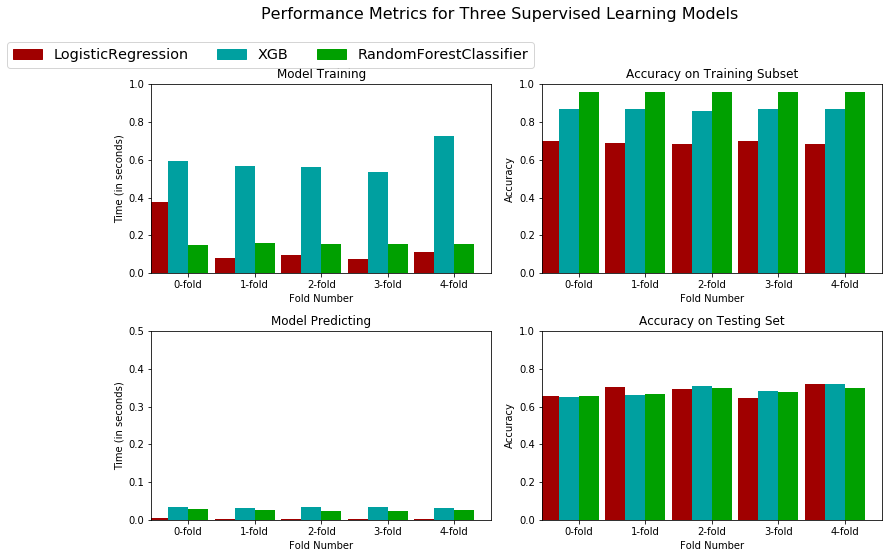

In [14]:
evaluate(results)

In [15]:
## Plotting Metrics

In [16]:
#Computing average accuracy score for Classifiers

def compute_avg(name):
    x_bar_train, x_bar_test = 0, 0

    for i in range(0,5):
        x_bar_train += results[str(name)][i]['acc_train']
        x_bar_test += results[name][i]['acc_test']

    x_bar_train/=5
    x_bar_test/=5

    print('Classifier : {0}\nMean Accuracy Score for training {1}, \nMean Accuracy Score for testing {2}'.format(name, x_bar_train,x_bar_test))

for learner in results.keys():
    if learner == 'module':
        compute_avg('XGB')
    else:
        compute_avg(str(learner))

Classifier : LogisticRegression
Mean Accuracy Score for training 0.692250498068, 
Mean Accuracy Score for testing 0.683678930272
Classifier : XGB
Mean Accuracy Score for training 0.867444218871, 
Mean Accuracy Score for testing 0.684641857946
Classifier : RandomForestClassifier
Mean Accuracy Score for training 0.960780384677, 
Mean Accuracy Score for testing 0.677582278172


In [17]:
# Model Tuning

In [18]:
X_tr = (X_train.loc[:,X_train.columns != 'match_id']).copy()
y_tr = (y_train.loc[:,y_train.columns != 'match_id']).copy().values.ravel()

In [19]:
parameter_test_1 = {
 'max_depth': np.arange(2,10,2),
 'min_child_weight':np.arange(1,12,2)
}

grid_search_1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=130, min_child_weight=1, max_depth=5,  gamma=0, \
                                                   subsample=0.8, objective= 'binary:logistic', nthread=4, \
                                                   scale_pos_weight=1, colsample_bytree=0.8, seed=27), param_grid = parameter_test_1, \
                                                   scoring='roc_auc', iid=False, n_jobs=4, cv=5)
grid_search_1.fit(X_tr,y_tr)
grid_search_1.grid_scores_, grid_search_1.best_params_, grid_search_1.best_score_

([mean: 0.79129, std: 0.03413, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.79183, std: 0.03444, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.79216, std: 0.03433, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.79243, std: 0.03431, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: 0.79283, std: 0.03512, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.79032, std: 0.03535, params: {'max_depth': 2, 'min_child_weight': 11},
  mean: 0.79658, std: 0.03637, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.79580, std: 0.03678, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.79624, std: 0.03725, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.79588, std: 0.03675, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.79617, std: 0.03679, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.79511, std: 0.03543, params: {'max_depth': 4, 'min_child_weight': 11},
  mean: 0.79481, std: 0.03715, params:

In [28]:
parameter_test_2 = {
 'subsample':[j / 100.0 for j in range(70,95,5)],
 'colsample_bytree':[j / 100.0 for j in range(70,95,5)]
}

grid_search_2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=130, min_child_weight=6, max_depth=3,  gamma=0, \
                                                   subsample=0.8, objective= 'binary:logistic', nthread=4, \
                                                   scale_pos_weight=1, colsample_bytree=0.8, seed=27), param_grid = parameter_test_1, \
                                                   scoring='roc_auc', iid=False, n_jobs=4, cv=5)
grid_search_2.fit(X_tr,y_tr)
grid_search_2.grid_scores_, grid_search_2.best_params_, grid_search_2.best_score_

([mean: 0.79129, std: 0.03413, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.79183, std: 0.03444, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.79216, std: 0.03433, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.79243, std: 0.03431, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: 0.79283, std: 0.03512, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.79032, std: 0.03535, params: {'max_depth': 2, 'min_child_weight': 11},
  mean: 0.79658, std: 0.03637, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.79580, std: 0.03678, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.79624, std: 0.03725, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.79588, std: 0.03675, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.79617, std: 0.03679, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.79511, std: 0.03543, params: {'max_depth': 4, 'min_child_weight': 11},
  mean: 0.79481, std: 0.03715, params:

In [29]:
parameter_test_3 = {
 'reg_alpha':[1e-07, 1e-05, 1e-03, 1e-5, 1e-2, 0, 100, 100]
}

grid_search_3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=130, min_child_weight=1, max_depth=5,  gamma=0, \
                                                   subsample=0.85, objective= 'binary:logistic', nthread=4, \
                                                   scale_pos_weight=1, colsample_bytree=0.85, seed=27), param_grid = parameter_test_1, \
                                                   scoring='roc_auc', iid=False, n_jobs=4, cv=5)
grid_search_3.fit(X_tr,y_tr)
grid_search_3.grid_scores_, grid_search_3.best_params_, grid_search_3.best_score_

([mean: 0.79199, std: 0.03445, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.79226, std: 0.03484, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.79188, std: 0.03498, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.79247, std: 0.03458, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: 0.79320, std: 0.03482, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.79204, std: 0.03553, params: {'max_depth': 2, 'min_child_weight': 11},
  mean: 0.79571, std: 0.03769, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.79612, std: 0.03752, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.79662, std: 0.03795, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.79577, std: 0.03792, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.79570, std: 0.03768, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: 0.79494, std: 0.03713, params: {'max_depth': 4, 'min_child_weight': 11},
  mean: 0.79399, std: 0.03606, params:

In [30]:
grid_search_3.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=130, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.85)

In [31]:
xgtrain = xgb.DMatrix(X_tr, label=y_tr)
model = xgb.train(grid_search_3.best_estimator_.get_xgb_params(), xgtrain, 200)
preds = model.predict(xgb.DMatrix((X_test.loc[:,X_test.columns != 'match_id']).copy()))

rounded_preds = [round(value) for value in preds]

accuracy = accuracy_score((y_test.loc[:,y_test.columns != 'match_id']).copy(),rounded_preds)
print('Accuracy of Tuned XGB is {0}'.format(accuracy))

Accuracy of Tuned XGB is 0.671314310419


In [32]:
cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'inn_wickets', 'inn_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']


test_indices = [item for item in range(0,633) if item not in train_indices]
sample_index = np.random.choice(test_indices,1)
sample_df = df.loc[df.match_id.isin(sample_index)]
sample_df = sample_df.loc[:,sample_df.columns != 'match_id']
sample_df.head()

,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,inn_wickets,inn_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
20515,1,1,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,2,0,0,2,-1.0,-1.0,2.000000,-1.0,-1.0,1,1
20516,1,2,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,11,0,0,13,-1.0,-1.0,6.500000,-1.0,-1.0,1,1
20517,1,3,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,10,0,0,23,-1.0,-1.0,7.666667,-1.0,-1.0,1,1
20518,1,4,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,13,0,0,36,-1.0,-1.0,9.000000,-1.0,-1.0,1,1
20519,1,5,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,9,0,0,45,-1.0,-1.0,9.000000,-1.0,-1.0,1,1


In [33]:
sample_preds = model.predict(xgb.DMatrix(sample_df[cols[:]]))

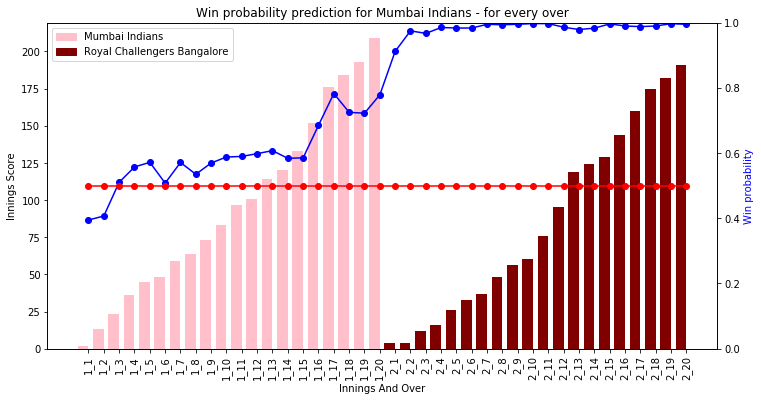

In [34]:
s_df = pd.DataFrame({'Team1':sample_df.team1.values})

s_df['inn_over'] = np.array(sample_df.apply(lambda r: str(r['inning']) + "_" + str(r['over']), axis=1))

s_df['inn_score'] = sample_df.inn_score.values

s_df['total_runs'] = sample_df.total_runs.values

s_df['predictions'] = list(sample_preds)

fig, g1 = plt.subplots(figsize=(12,6))

g2 = g1.twinx()

labels = np.array(s_df['inn_over'])

index = np.arange(len(labels))

bars = g1.bar(index, np.array(s_df['inn_score']), width=0.7, color=['pink']*20 + ['maroon']*20)

#adding legends to plt 
team1=sample_df['team1'].iloc[0]
team2=sample_df['team2'].iloc[0]
patch1 = mpatches.Patch(color='pink', label= team1)
patch2 = mpatches.Patch(color='maroon', label= team2)
plt.legend(handles=[patch1,patch2],loc='upper left')
#end

g1.set_xticks(index + ((0.7)/2))

g1.set_xticklabels(labels, rotation='vertical')

g1.set_ylabel("Innings Score")

g1.set_xlabel("Innings And Over")

g1.set_title("Win probability prediction for {0} - for every over".format(s_df.Team1.values[0]))

g2.plot(index + 0.35, np.array(s_df['predictions']), color='b', marker='o')

g2.plot(index + 0.35, np.array([0.5]*len(labels)), color='red', marker='o')

g2.set_ylabel("Win probability", color='b')

g2.set_ylim([ 0 , 1])

g2.grid(b=False)

plt.show()

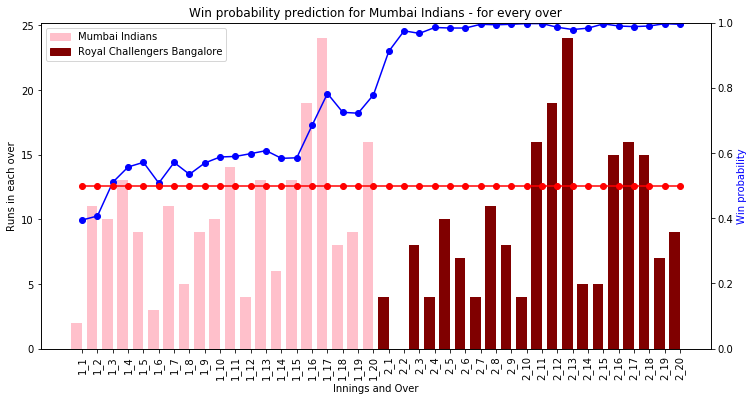

In [35]:
fig, g1 = plt.subplots(figsize=(12,6))

g2 = g1.twinx()

labels = np.array(s_df['inn_over'])

index = np.arange(len(labels))

bars = g1.bar(index , np.array(s_df['total_runs']), width=0.7, color=['pink']*20 + ['maroon']*20)

#adding legends to plt

team1=sample_df['team1'].iloc[0]
team2=sample_df['team2'].iloc[0]
patch1 = mpatches.Patch(color='pink', label= team1)
patch2 = mpatches.Patch(color='maroon', label= team2)
plt.legend(handles=[patch1,patch2],loc='upper left')
#end

g1.set_xticks(index + ((0.7)/2))

g1.set_xticklabels(labels, rotation='vertical')

g1.set_ylabel("Runs in each over")

g1.set_xlabel("Innings and Over")

g1.set_title("Win probability prediction for {0} - for every over".format(s_df.Team1.values[0]))

g2.plot(index + 0.35, np.array(s_df['predictions']), color='blue', marker='o')

g2.plot(index + 0.35, np.array([0.5]*len(labels)), color='red', marker='o')

g2.set_ylabel("Win probability", color='blue')

g2.set_ylim([0,1])

g2.grid(b=False)

plt.show()